In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
from matplotlib.pyplot import figure, imshow, axis

from nltk.translate.bleu_score import sentence_bleu

import seaborn as sns

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import Counter

from tqdm import tqdm
import re
import numpy as np
import pandas as pd
import os
import time
import json
from glob import glob
from PIL import Image

import imageio
import pickle
import datetime

In [2]:
tf.__version__

PATH= "/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic"

In [3]:
# ## Read annotation json file 

with open(PATH + "/all_caption.json", 'r') as f:
    annotations = json.load(f)

len(annotations)

annotations[:10]

[{'caption': 'banyak jenis bunga di merapi park',
  'image_id': '0cv1krzup6x45sq3i8hb.jpg'},
 {'caption': 'banyak jenis bunga di merapi park',
  'image_id': '0jcymwz1atpn2fhi6s54.jpg'},
 {'caption': 'tempat cukup luas dan pemandangan yang membuat tidak ingin pulang',
  'image_id': '0y6txkj1b7eqmw9gpunc.jpg'},
 {'caption': 'tempat cukup luas dan pemandangan yang membuat tidak ingin pulang',
  'image_id': '1ho0rsaj76pnl4muibzy.jpg'},
 {'caption': 'banyak jenis bunga di merapi park',
  'image_id': '2b8e76qsg34umi9lxktc.jpg'},
 {'caption': 'ingin lihat miniatur wisata diberbagai belahan dunia yuk ke merapi park',
  'image_id': '2ziuvk0d9aylptscgxj3.jpg'},
 {'caption': 'cocok untuk liburan bersama keluarga',
  'image_id': '3mu6nrfa841hwjbp9507.jpg'},
 {'caption': 'bagi ingin berfoto bersama kekasih sangat sesuai',
  'image_id': '3zaemw08qpghy27fbdv4.jpg'},
 {'caption': 'bagi ingin berfoto bersama kekasih sangat sesuai',
  'image_id': '4kbys2n1x7ovi9drepl5.jpg'},
 {'caption': 'bagi ingin ber

In [4]:
# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_image_path = PATH + '/dataset_efficientNetB4/' + '{IMG}'.format(IMG=image_id)
    all_img_name_vector.append(full_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

print(train_captions[:5])

print(img_name_vector[:5])

['<start> terlihat sangat indah saat berada disana <end>', '<start> polisi dan dishub sedang bertugas di malioboro <end>', '<start> outfit hitam putih yang membuat semakin keren <end>', '<start> pendaki wanita di saat mendaki gunung <end>', '<start> tempat wisata air yang sangat cantik cocok untuk bertamasya <end>']
['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/g0zn9vdph2wbqy6s43cu.png', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/Selasa-Wage-Jalan-Malioboro.jpg', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/nh64tc0r9yzjp1sg3odf.jpg', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/m9uiofeac57xtl8gyz14.jpg', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/ixwkmtvchpj2g5e308yr.jpg']


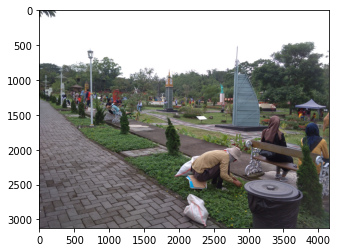

<start> bagi ingin berfoto bersama kekasih sangat sesuai <end>
(3120, 4160, 3)


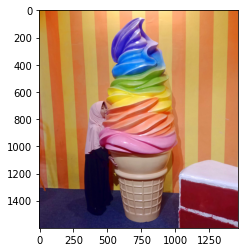

<start> ada bola putih dan biru yang membuatkan selalu rindu <end>
(1600, 1459, 3)


In [5]:
%matplotlib inline

img=mpimg.imread(img_name_vector[1200])
imgplot = plt.imshow(img)
plt.show()

print(train_captions[1200])
print(img.shape)
# print(img)

img=mpimg.imread(img_name_vector[121])
imgplot = plt.imshow(img)
plt.show()

print(train_captions[121])
print(img.shape)
# print(img)

In [6]:
len(train_captions), len(all_captions)

(1696, 1696)

In [7]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (380, 380))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, image_path

In [8]:
image_model = tf.keras.applications.EfficientNetB4(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_______________________________________________________________________________________

In [9]:
# Get unique images
encode_train = sorted(set(img_name_vector))
print(len(encode_train)) # 
print(encode_train[:5])

1696
['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/021u3yagso4qhwxndkbf.jpg', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/02jsutdihcmo58exvz7q.jpeg', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/04z6v1thy3xomadl5s7i.jpg', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/05s1uyjav6hzm3g7rfit.png', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/06kzxd92bc5h78g3lijr.jpeg']


In [10]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

image_dataset

<TensorSliceDataset shapes: (), types: tf.string>

In [11]:
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16) # map functional programming

image_dataset

<BatchDataset shapes: ((None, 380, 380, 3), (None,)), types: (tf.float32, tf.string)>

In [12]:
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img) # image features extractor model
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path): # bf : batch feature , p : path
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
# - `store the resulting vector` `in a dictionary` (image_name --> feature_vector).
# - you pickle the dictionary and save it to disk.

100%|██████████| 106/106 [01:16<00:00,  1.39it/s]


In [13]:
np_img =np.load('/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/04z6v1thy3xomadl5s7i.jpg.npy')

print(np_img)
print("Shape : {}".format(np_img.shape))

[[-0.26974967 -0.23321873 -0.20915079 ... -0.27234855 -0.21221957
  -0.26846975]
 [-0.26703462 -0.21350263 -0.21641064 ... -0.22484736 -0.27674547
  -0.24349792]
 [-0.26163256 -0.21706702 -0.2244059  ... -0.23535043 -0.27580798
  -0.2504866 ]
 ...
 [-0.27769476 -0.23941262 -0.11578567 ... -0.26693407 -0.26114577
  -0.25967532]
 [-0.26730484 -0.27558774 -0.11440971 ... -0.25738966 -0.2476202
  -0.2547577 ]
 [-0.2710415  -0.2120963  -0.08882961 ... -0.2603892  -0.2479976
  -0.27745202]]
Shape : (121, 1792)


In [14]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

dict_df = {"filename":img_name_vector,"caption":train_captions}

df = pd.DataFrame(dict_df)

for i, v in enumerate(df.values) :
    print(i, v)
    if i == 2:
        break

0 ['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/g0zn9vdph2wbqy6s43cu.png'
 '<start> terlihat sangat indah saat berada disana <end>']
1 ['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/Selasa-Wage-Jalan-Malioboro.jpg'
 '<start> polisi dan dishub sedang bertugas di malioboro <end>']
2 ['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/nh64tc0r9yzjp1sg3odf.jpg'
 '<start> outfit hitam putih yang membuat semakin keren <end>']


In [15]:
def utility_counter(data):

  unique_filenames = np.unique(data.filename.values)
#   print("The number of unique file names : {}".format(len(unique_filenames)))

  ct_dict = Counter(data.filename.values)
#   print(ct_dict)

#   print("The distribution of the number of captions for each image:", 1)
  ct = Counter(Counter(data.filename.values).values())
#   print(ct)
  return unique_filenames


unique_filenames = utility_counter(df)

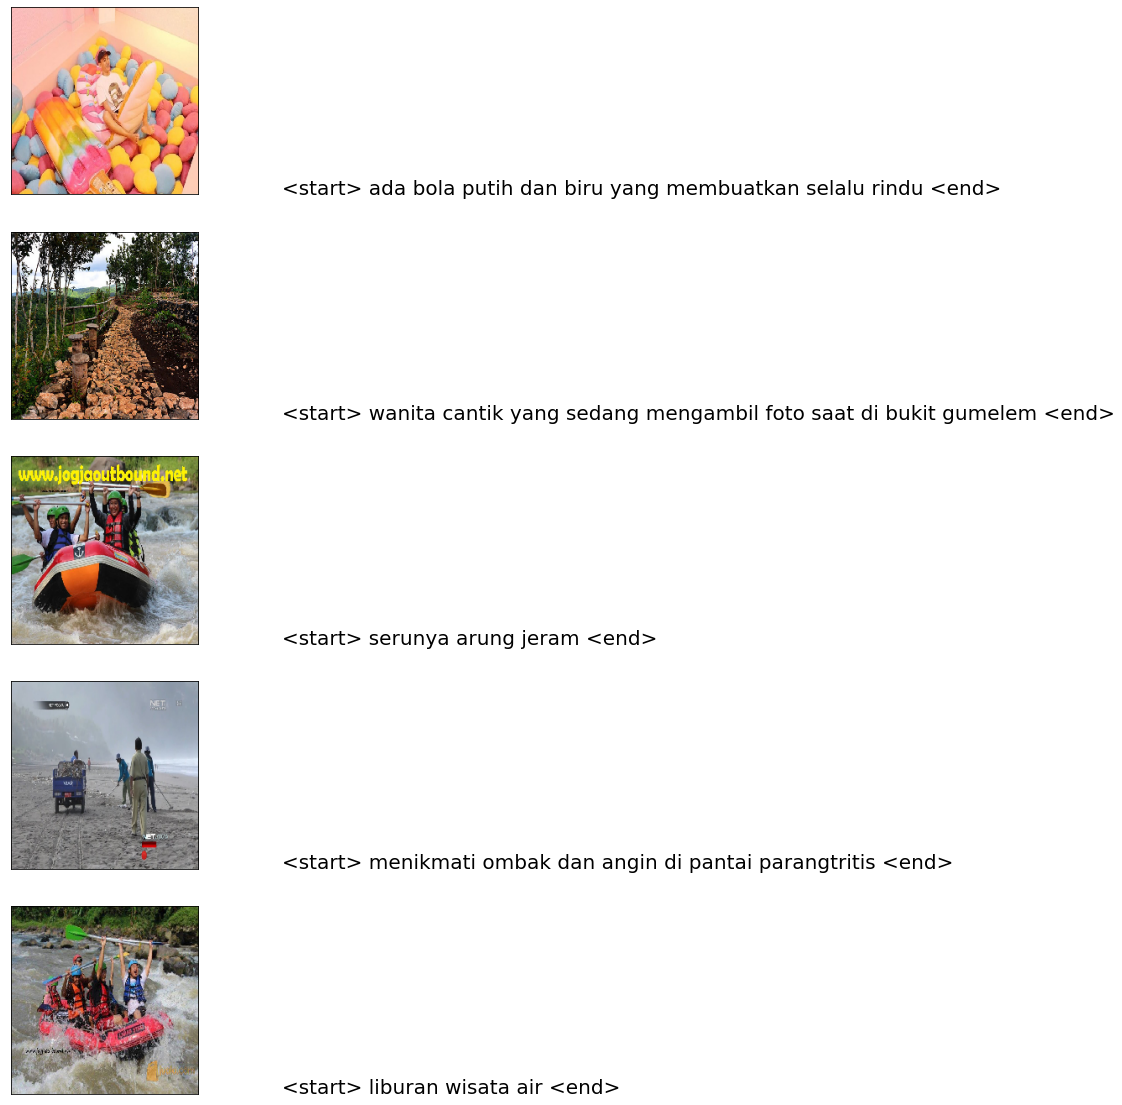

In [16]:
def image_desc_plotter(data):
  npic = 5
  npix = 224
  target_size = (npix,npix,3)

  count = 1
  fig = plt.figure(figsize=(10,20))
  for jpgfnm in unique_filenames[20:25]:
      filename = jpgfnm
      captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
      image_load = load_img(filename, target_size=target_size)
      
      ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
      ax.imshow(image_load)
      count += 1
      
      ax = fig.add_subplot(npic,2,count)
      plt.axis('off')
      ax.plot()
      ax.set_xlim(0,1)
      ax.set_ylim(0,len(captions))
      for i, caption in enumerate(captions):
          ax.text(0,i,caption,fontsize=20)
      count += 1
  plt.show()

image_desc_plotter(df)

In [17]:
def create_vocabulary(data):
  vocab = []
  for captions in data.caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab


vocabulary = create_vocabulary(df)

Vocabulary Size : 291


In [18]:
def df_word_count(data,vocabulary):
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

dfwordcount = df_word_count(df,vocabulary)

dfwordcount.iloc[:10,:]

word  count
0  <start>   1696
1    <end>   1696
2       di    539
3     yang    481
4   sangat    247
5   tempat    240
6    untuk    232
7      dan    200
8     dari    192
9   wisata    171

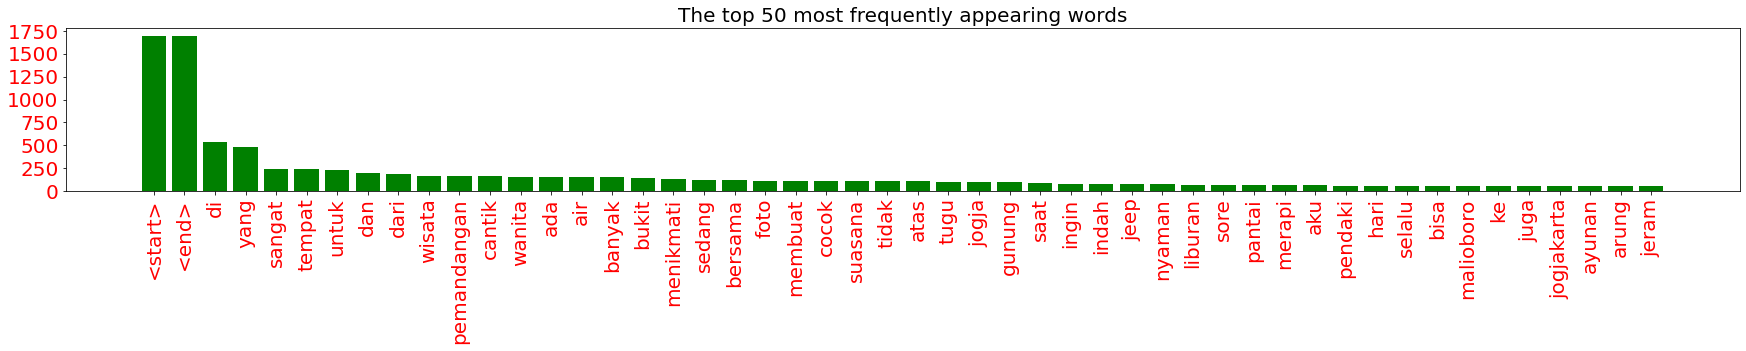

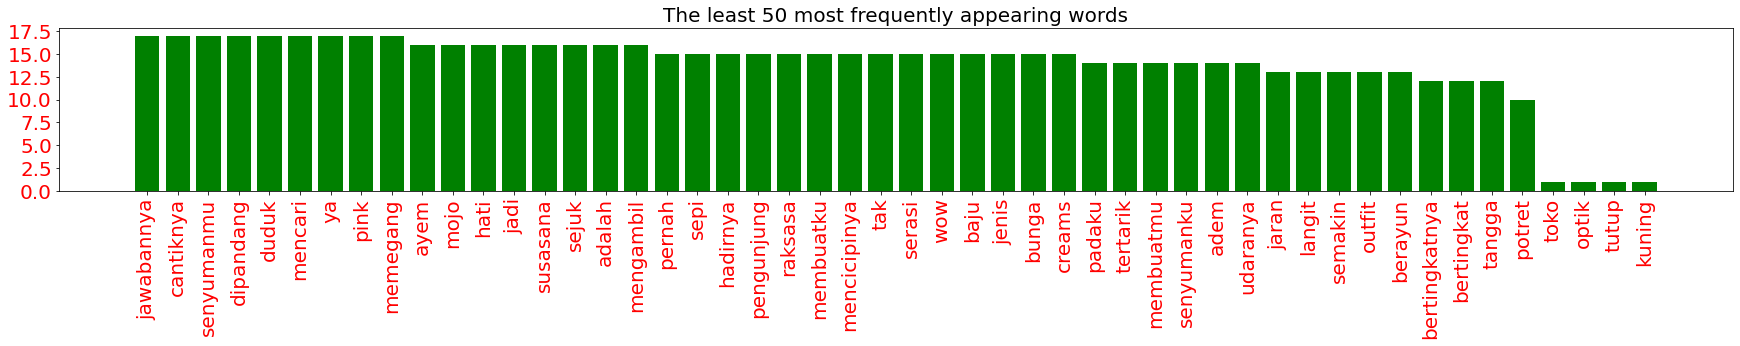

In [19]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"],color ='g')
    plt.yticks(fontsize=20,color ='r')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20,color ='r')
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfwordcount.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

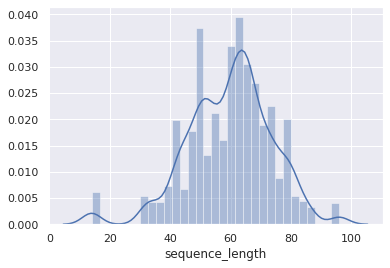

In [20]:
# df=pd.DataFrame()
df["sequence_length"] = df["caption"].apply(len)

sns.set()
distribution = sns.distplot(df["sequence_length"])

In [21]:
print(df.loc[0])
print(df.caption[0])
print(df.sequence_length[0])
print(len(df.caption[0]))

filename           /home/yurio/mainan_yurio/img_cap_to_icitda/img...
caption            <start> terlihat sangat indah saat berada disa...
sequence_length                                                   54
Name: 0, dtype: object
<start> terlihat sangat indah saat berada disana <end>
54
54


In [22]:
# Choose the top 5000 words from the vocabulary
top_k = 290
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


print(train_seqs[:5])

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

print(tokenizer.index_word[0])

print(tokenizer.oov_token)

# print(tokenizer.word_counts)

[[2, 113, 6, 37, 23, 54, 110, 3], [2, 196, 9, 197, 20, 198, 4, 35, 3], [2, 273, 71, 86, 5, 24, 274, 72, 3], [2, 43, 14, 4, 23, 66, 31, 3], [2, 7, 11, 16, 5, 6, 13, 25, 8, 199, 3]]
<pad>
<unk>


In [23]:
# print(tokenizer.word_index.items()[:5])
for i, (k,v) in enumerate(tokenizer.word_index.items()):
  print(i,k,v)
  if i == 10:
    break

# print(tokenizer.index_word.items()[:5])
print("-"*10)
for i, (k,v) in enumerate(tokenizer.index_word.items()):
  print(i,k,v)
  if i == 10:
    break

len(tokenizer.word_index.items())

0 <unk> 1
1 <start> 2
2 <end> 3
3 di 4
4 yang 5
5 sangat 6
6 tempat 7
7 untuk 8
8 dan 9
9 dari 10
10 wisata 11
----------
0 1 <unk>
1 2 <start>
2 3 <end>
3 4 di
4 5 yang
5 6 sangat
6 7 tempat
7 8 untuk
8 9 dan
9 10 dari
10 11 wisata


286

In [24]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

train_seqs[:5]

[[2, 113, 6, 37, 23, 54, 110, 3],
 [2, 196, 9, 197, 20, 198, 4, 35, 3],
 [2, 273, 71, 86, 5, 24, 274, 72, 3],
 [2, 43, 14, 4, 23, 66, 31, 3],
 [2, 7, 11, 16, 5, 6, 13, 25, 8, 199, 3]]

In [25]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

print(cap_vector.shape)

print(cap_vector[:5])

(1696, 15)
[[  2 113   6  37  23  54 110   3   0   0   0   0   0   0   0]
 [  2 196   9 197  20 198   4  35   3   0   0   0   0   0   0]
 [  2 273  71  86   5  24 274  72   3   0   0   0   0   0   0]
 [  2  43  14   4  23  66  31   3   0   0   0   0   0   0   0]
 [  2   7  11  16   5   6  13  25   8 199   3   0   0   0   0]]


In [26]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

max_length

15

In [27]:
five_images = all_img_name_vector[:5]
unique_images = np.unique(five_images)
print(unique_images)

['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/0cv1krzup6x45sq3i8hb.jpg'
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/0jcymwz1atpn2fhi6s54.jpg'
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/0y6txkj1b7eqmw9gpunc.jpg'
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/1ho0rsaj76pnl4muibzy.jpg'
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/2b8e76qsg34umi9lxktc.jpg']


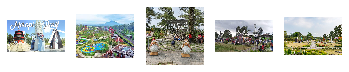

In [28]:
def showImagesHorizontally(five_images):
    fig = figure()
    number_of_files = len(five_images)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(five_images[i])
        imshow(image,cmap='Greys_r', aspect='equal', interpolation='nearest')
        axis('off')

showImagesHorizontally(unique_images)

In [29]:
print("Total Images : " + str(len(all_img_name_vector)))
print("Total Captions : " + str(len(train_captions)))

# ## Split the data into training and testing
len(img_name_vector)

Total Images : 1696
Total Captions : 1696


1696

In [30]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)


print(len(img_name_train), len(cap_train), len(img_name_val), len(cap_val))

1356 1356 340 340


In [31]:
print(img_name_train[:5])

print(cap_train[:5])

# To know the shape of images
def img_shape_finder(image):
    img= plt.imread(image)

    print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[-1],img.shape))
    

['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/0am496j2ucit81wke57h.jpg', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/qkngie2r8sd0t3jfwbhv.jpg', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/y0clih39tnfmrjqsxzea.jpg', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/po5v2lica70tf3mz8jnr.jpg', '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/jyu7nqrc8fs56k3blvth.jpg']
[[  2 135  12  10  28  18  82   3   0   0   0   0   0   0   0]
 [  2  15  58  86   9 117   5 118  45 119   3   0   0   0   0]
 [  2 161 162   5  24 102  38  28 163   5   4 164   3   0   0]
 [  2  43  14   4  23  66  31   3   0   0   0   0   0   0   0]
 [  2  39  11  16   3   0   0   0   0   0   0   0   0   0   0]]


In [32]:
img_list=[]
for i in range(5):
  img_list.append(img_name_vector[i])

for j in img_list:
  img_shape_finder(j)

Shape of the image ==> g0zn9vdph2wbqy6s43cu.png is ==> (521, 768, 3)
Shape of the image ==> Selasa-Wage-Jalan-Malioboro.jpg is ==> (544, 970, 3)
Shape of the image ==> nh64tc0r9yzjp1sg3odf.jpg is ==> (877, 750, 3)
Shape of the image ==> m9uiofeac57xtl8gyz14.jpg is ==> (291, 320, 3)
Shape of the image ==> ixwkmtvchpj2g5e308yr.jpg is ==> (640, 640, 3)


Shape of the image:(479, 480, 3)


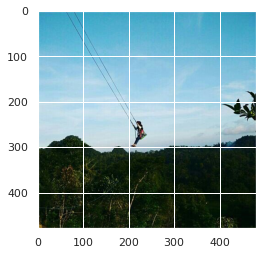

In [33]:
# To know the shape of images
def image_and_shapes(image):
  img= plt.imread(image)
  plt.imshow(img)
  print("Shape of the image:{}".format(img.shape))

image_and_shapes('/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/uzd0vngkpsbw9c6e7q5y.jpg')

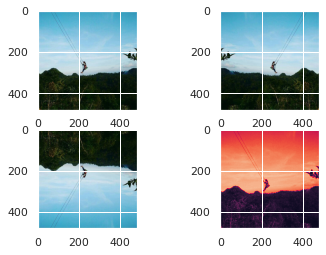

In [34]:
def image_flipper(image):
  original_img = imageio.imread(image)
  
  plt.figure(1)

#Original Image

  plt.subplot(221)
  plt.imshow(original_img)

#Left-Right flip Image

  flipped_img_tensor = tf.image.flip_left_right(original_img)
  flipped_img= flipped_img_tensor.numpy()
  plt.subplot(222)
  plt.imshow(flipped_img)

#Up-Down flip Image

  upside_down_flip_tensor = tf.image.flip_up_down(original_img)
  upside_down_flip= upside_down_flip_tensor.numpy()
  plt.subplot(223)
  plt.imshow(upside_down_flip)

#Gray scale Image

  gray_tensor = tf.image.rgb_to_grayscale(original_img)
  grayimg= gray_tensor.numpy()
  plt.subplot(224)
  plt.imshow(tf.squeeze(grayimg))

#plt.imsave('doggo.jpg',flipped_img)

image_flipper('/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/uzd0vngkpsbw9c6e7q5y.jpg')

In [35]:
t = tf.constant([[1, 2], [3, 4]])
ds = tf.data.Dataset.from_tensor_slices(t)   # [1, 2], [3, 4]
ds

t.numpy()

t.numpy().shape

(2, 2)

In [36]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE  # 384 / 64

print(num_steps)

21


In [37]:
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 1792
attention_features_shape = 121

In [38]:
# img_name_train, img_name_val, cap_train, cap_val
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [39]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


print(dataset)
print(test_dataset)

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>


In [40]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # vector_size 512 + vector_size 512

    # attention_weights shape == (batch_size, 64, 1) # from 512 --> 1 fc
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
#     print("attention_weights: ",attention_weights)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features # dot_prod feature x attention
    context_vector = tf.reduce_sum(context_vector, axis=1) # vector sum

    return context_vector, attention_weights

In [41]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [42]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
#     self.gru = tf.compat.v1.keras.layers.CuDNNLSTM(self.units, 
#                                         return_sequences=True, 
#                                         return_state=True, 
#                                         recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [43]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

print(encoder)
print(decoder)

In [44]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [45]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [46]:
checkpoint_path = PATH + "/checkpoints/efficientNetB4"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [47]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [48]:
# !mkdir ./logs
!mkdir ./logs/efficientNetB4

In [49]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

In [50]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/efficientNetB4/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/efficientNetB4/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [51]:
loss_plot = []

@tf.function
def train_step(img_tensor, target): # input from img tensor, n target word captions
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) # decide input
  
#   print("target.shape[0]: ", target.shape[0])
#   print("dec_input: ", dec_input)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)  # 64 x 256
#       print("target.shape[1]: ", target.shape[1])

      for i in range(1, target.shape[1]): # loop over the target
          # passing the features through the decoder
          # overwrite hidden from attention
          predictions, hidden, _ = decoder(dec_input, features, hidden)
#           print(i)

          loss += loss_function(target[:, i], predictions)
#           print("target[:, i]: ", target[:, i])

          # using teacher forcing # overwrite new decide_input
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [52]:
test_loss_plot = []

@tf.function
def test_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  features = encoder(img_tensor)

  for i in range(1, target.shape[1]):
      # passing the features through the decoder
     
      predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
      # predictions : (64,8329)
      loss += loss_function(target[:, i], predictions)
      
      predicted_id = tf.argmax(predictions[0])
#       predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
#       dec_input = tf.expand_dims([predicted_id]*target.shape[0], 1)
      dec_input = tf.expand_dims(target[:, i], 1)
 

  total_loss = (loss / int(target.shape[1]))

  return loss, total_loss

In [53]:
EPOCHS = 25

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    
    
    #For Train
    total_loss_train = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss_train / num_steps)
    
    # Tensorboard 
    with train_summary_writer.as_default():
      tf.summary.scalar('LossPlotTrain', (total_loss_train/ num_steps), step=epoch)
      tf.summary.scalar('Train_loss', train_loss.result(), step=epoch)
        
    
    #For Test
    total_loss_test = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
    # storing the epoch end loss value to plot later
    test_loss_plot.append(total_loss_test / num_steps) 

    # Tensorboard 
    with test_summary_writer.as_default():
      tf.summary.scalar('LossPlotTest', (total_loss_test/ num_steps), step=epoch)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(epoch + 1,(total_loss_train/num_steps),(total_loss_test/num_steps)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.0052
Epoch 1 TrainLoss 2.850382 TestLoss 0.721350
Time taken for 1 epoch 22.217942476272583 sec

Epoch 2 Batch 0 Loss 2.5135
Epoch 2 TrainLoss 2.250196 TestLoss 0.502998
Time taken for 1 epoch 2.141307830810547 sec

Epoch 3 Batch 0 Loss 1.5642
Epoch 3 TrainLoss 1.451972 TestLoss 0.316673
Time taken for 1 epoch 2.0365090370178223 sec

Epoch 4 Batch 0 Loss 0.9707
Epoch 4 TrainLoss 0.782707 TestLoss 0.202829
Time taken for 1 epoch 2.0358550548553467 sec

Epoch 5 Batch 0 Loss 0.4758
Epoch 5 TrainLoss 0.441560 TestLoss 0.149711
Time taken for 1 epoch 2.826545000076294 sec

Epoch 6 Batch 0 Loss 0.2959
Epoch 6 TrainLoss 0.311572 TestLoss 0.134587
Time taken for 1 epoch 2.0944650173187256 sec

Epoch 7 Batch 0 Loss 0.2089
Epoch 7 TrainLoss 0.237082 TestLoss 0.139885
Time taken for 1 epoch 2.070310115814209 sec

Epoch 8 Batch 0 Loss 0.1663
Epoch 8 TrainLoss 0.181259 TestLoss 0.139691
Time taken for 1 epoch 2.049604654312134 sec

Epoch 9 Batch 0 Loss 0.1554
Epoch 9 TrainLos

In [54]:
%load_ext tensorboard
%tensorboard --logdir logs/efficientNetB4/gradient_tape

In [55]:
ckpt_manager.checkpoints

['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/checkpoints/efficientNetB4/ckpt-1',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/checkpoints/efficientNetB4/ckpt-2',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/checkpoints/efficientNetB4/ckpt-3',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/checkpoints/efficientNetB4/ckpt-4',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/checkpoints/efficientNetB4/ckpt-5']

No handles with labels found to put in legend.


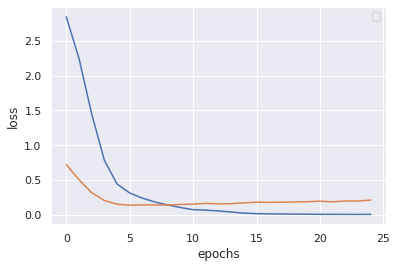

In [56]:
for label in [loss_plot,test_loss_plot]:
    plt.plot(label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [57]:
ckpt.restore('./checkpoints/efficientNetB4/ckpt-3')

In [58]:
## greedy search
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
#         predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [59]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
#         ax = fig.add_subplot(len_result, len_result, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> selalu ada pengunjung dan tak pernah sepi tidak seperti hadirnya <end>
Prediction Caption: bermain air juga sangat menyenangkan <end>


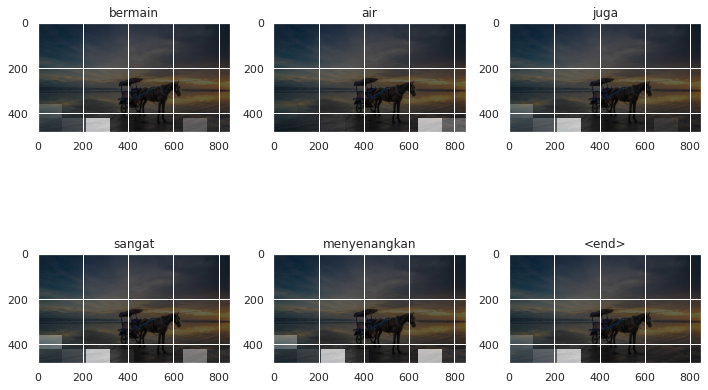

In [60]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNetB4/fjmdxvsn3el7qui4wr1g.jpeg
[  2 113   6  37  23  54 110   3   0   0   0   0   0   0   0]
<start> terlihat sangat indah saat berada disana <end>


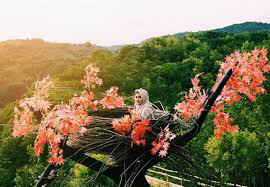

In [61]:
# taking random picture
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
print(cap_val[rid])

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
print(real_caption)
Image.open(img_name_val[rid])

In [62]:
# counting time
# start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('this is result: ', result)
# print('this is attention_plot: ', attention_plot)

this is result:  ['ada', 'jembatan', 'yang', 'bisa', 'melihat', 'keadaan', 'yang', 'dari', 'atas', '<end>']


In [63]:
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

print(first)
print(real_caption)


#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]
print(result_join)
print(result_final)

terlihat sangat indah saat berada disana <end>
terlihat sangat indah saat berada disana
ada jembatan yang bisa melihat keadaan yang dari atas <end>
ada jembatan yang bisa melihat keadaan yang dari atas


[['terlihat', 'sangat', 'indah', 'saat', 'berada', 'disana']]
['terlihat', 'sangat', 'indah', 'saat', 'berada', 'disana']
['ada', 'jembatan', 'yang', 'bisa', 'melihat', 'keadaan', 'yang', 'dari', 'atas']
BLEU score: 0
Real Caption: terlihat sangat indah saat berada disana
Prediction Caption: ada jembatan yang bisa melihat keadaan yang dari atas


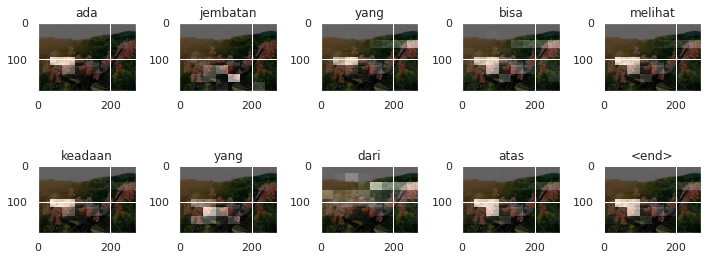

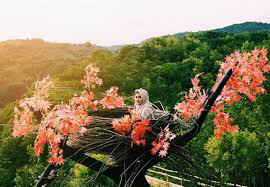

In [64]:
real_appn = []
real_appn.append(real_caption.split())
reference = real_caption.split()
candidate = result_final.split()

print(real_appn)
print(reference)
print(candidate)

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)

Image.open(img_name_val[rid])

/home/yurio/anaconda3/envs/img_cap/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/yurio/anaconda3/envs/img_cap/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU score: 53.62560368285115
Real Caption: ibu ibu sedang menaiki becak di malioboro
Prediction Caption: ibu sedang bertugas di malioboro


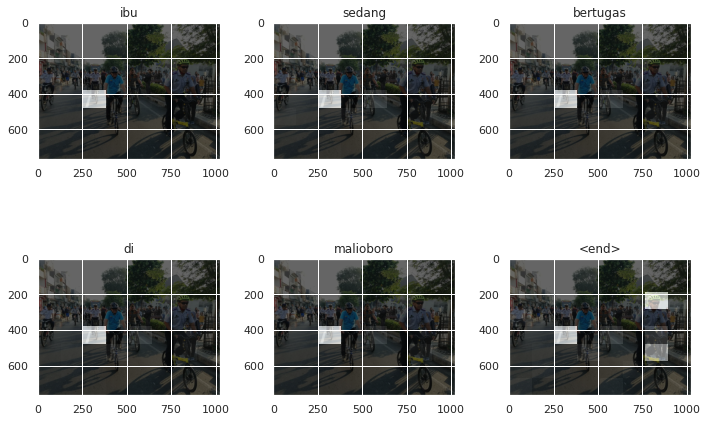

time took to Predict: 1 sec


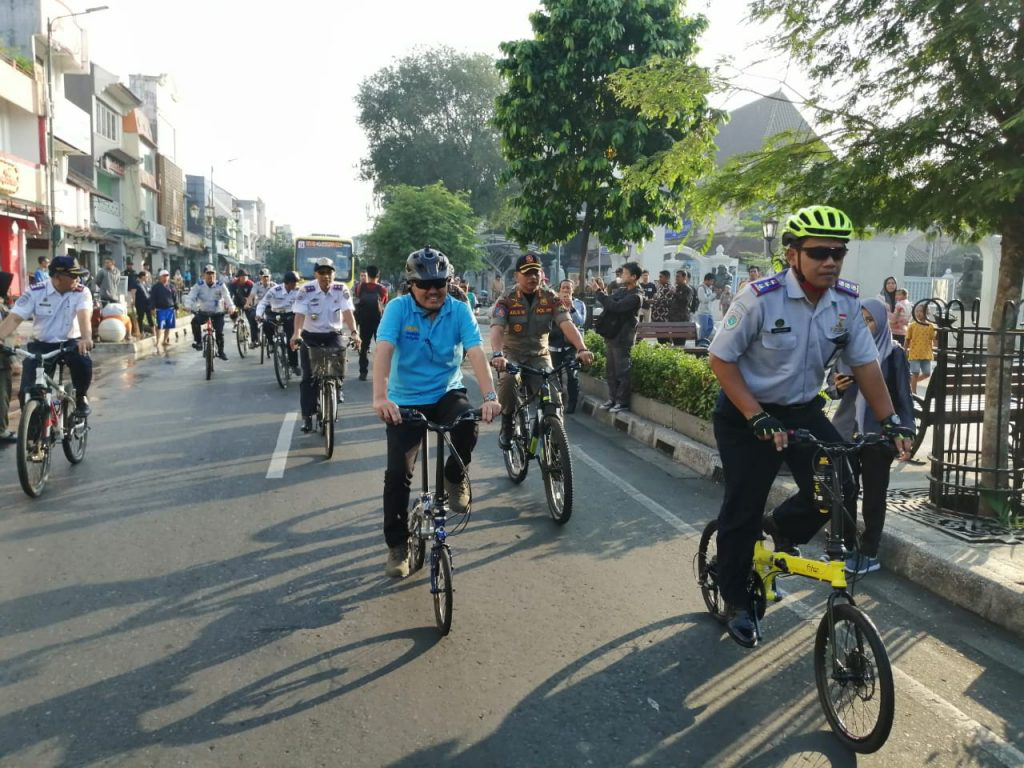

In [65]:
# taking random picture
rid = np.random.randint(0, len(img_name_train))
image = img_name_train[rid]
# print(image)
# print(cap_train[rid])

# counting time
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_train[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()
# print("reference: ", reference)
# print("candidate: ", candidate)

score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_train[rid])

BLEU score: 50.0
Real Caption: menikmati pemandangan dari bukit paralayang
Prediction Caption: tempat yang menawan dari bukit paralayang


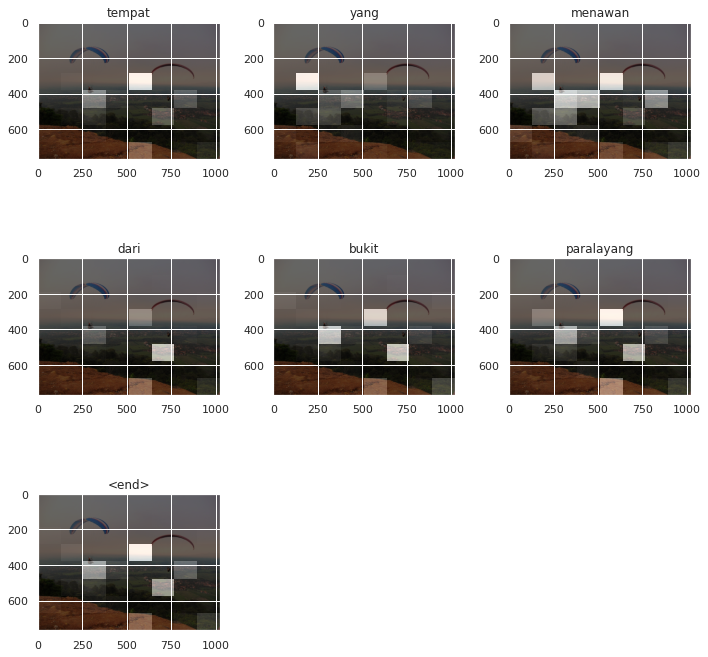

time took to Predict: 2 sec


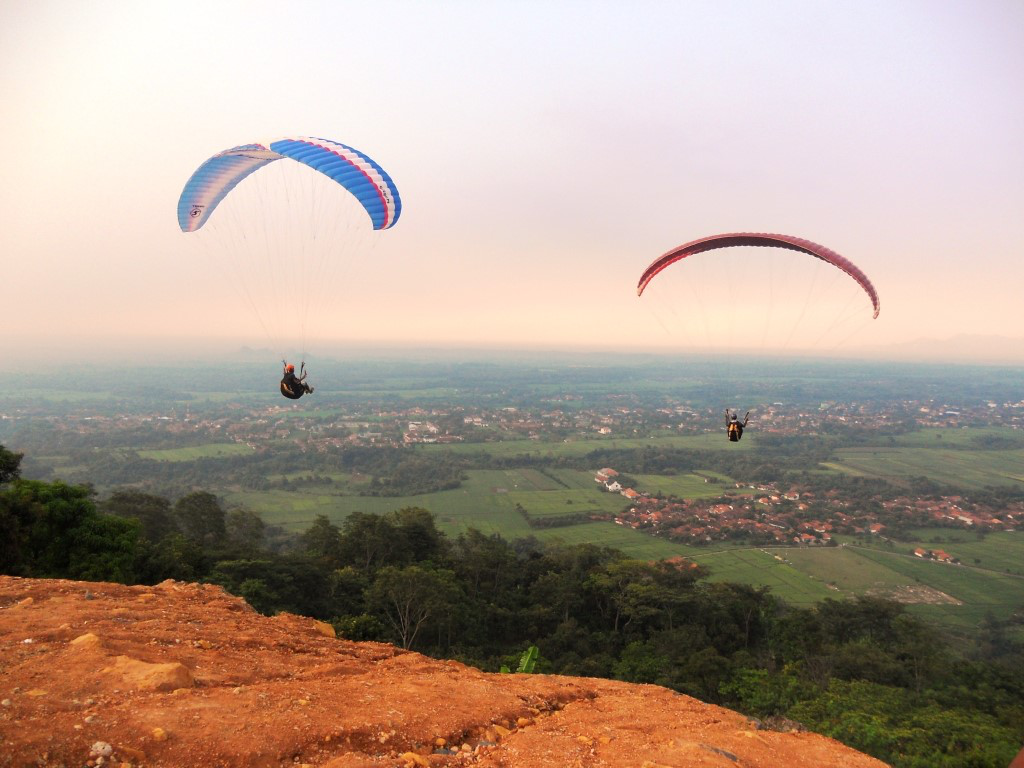

In [66]:
# captions on the validation set

# taking random picture
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
# print(image)
# print(cap_val[rid])

# counting time
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()
# print("reference: ", reference)
# print("candidate: ", candidate)

score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])

In [67]:
### counting BLEU score on training set
# taking random picture

bleu_train_score = []
inference_train_perform = []
for rid in range(0,len(img_name_train)):
  # rid = np.random.randint(0, len(img_name_train))
  image = img_name_train[rid]
#   print(image)
#   print(cap_train[rid])

  # counting time
  start = time.time()
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_train[rid] if i not in [0]])
  result, attention_plot = evaluate(image)

  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  #remove "<unk>" in result
  for i in result:
      if i=="<unk>":
          result.remove(i)

  #remove <end> from result         
  result_join = ' '.join(result)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = result_final.split()
#   print("reference: ", reference)
#   print("candidate: ", candidate)

  score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#   print(f"BLEU score: {score*100}")
  bleu_train_score.append(score*100)

#   print ('Real Caption:', real_caption)
#   print ('Prediction Caption:', result_final)

  # plot_attention(image, result, attention_plot)

#   print(f"time took to Predict: {round(time.time()-start)} sec")
  inference_train_perform.append(round(time.time()-start))
  # opening the image
  Image.open(img_name_train[rid])
#   break

/home/yurio/anaconda3/envs/img_cap/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [68]:
# tokenizer.index_word

In [69]:
# bleu_train_score

In [70]:
# inference_train_perform

In [71]:
### counting BLEU score on val set
bleu_val_score = []
for rid in range(0,len(img_name_val)):
  # rid = np.random.randint(0, len(img_name_train))
  image = img_name_val[rid]
#   print(image)
#   print(cap_val[rid])

  # counting time
  start = time.time()
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)

  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  #remove "<unk>" in result
  for i in result:
      if i=="<unk>":
          result.remove(i)

  #remove <end> from result         
  result_join = ' '.join(result)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = result_final.split()
#   print("reference: ", reference)
#   print("candidate: ", candidate)

  score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#   print(f"BLEU score: {score*100}")
  bleu_val_score.append(score*100)

#   print ('Real Caption:', real_caption)
#   print ('Prediction Caption:', result_final)

  # plot_attention(image, result, attention_plot)

#   print(f"time took to Predict: {round(time.time()-start)} sec")
  # opening the image
  Image.open(img_name_val[rid])
  

In [72]:
# bleu_val_score

In [73]:
# Python program to get average of a list 
def Average(lst): 
    return sum(lst) / len(lst) 
  
# Driver Code 
# bleu_train_score
# bleu_val_score
average_bts = Average(bleu_train_score) 
average_bvs = Average(bleu_val_score) 
  
# Printing average of the list 
print("Average of the bleu_train_score =", round(average_bts, 2)) 
print("Average of the bleu_val_score =", round(average_bvs, 2)) 

Average of the bleu_train_score = 72.84
Average of the bleu_val_score = 22.24
